In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import dask
import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
from xhistogram.xarray import histogram

from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [15]:
run_dedalus = False # Dedalus only works on login nodes; MITgcm analysis has to work on compute nodes.

In [16]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 60.

### Run / load 1D Dedalus simulations

In [17]:
T = 4900*86400
names = ['default', 'f=0', 'Pr=230']

bbl_runs = {
    'default': {},
    'f=0': {'f': 0.},
    'Pr=230': {'σ': 230.},
    'theta=0': {'θ': 0.}
}
bbl_output = {}

for name, kwargs in bbl_runs.items():
    if run_dedalus:
        from bbl import *
        for t in np.arange((200*86400), T, (200*86400)):
            path = f"../../data/dedalus/transient/BBTRE-{name}_{t}.nc"
            bbl = bbl_exp_spinup(T=t, dt=T/100., **kwargs)
            bbl_output[name] = bbl_to_ds(bbl).expand_dims(dim={'time': np.array([t])})
            bbl_output[name].to_netcdf(path)

    else:
        path = f"../../data/dedalus/transient/BBTRE-{name}_*.nc"
        pathstr = path.split("/")[-1]
        print(f"Loading {pathstr}")
        bbl_output[name] = xr.open_mfdataset(path, combine="by_coords", concat_dim='time')
        bbl_output[name]['time'] = bbl_output[name]['time']/86400.

Loading BBTRE-default_*.nc
Loading BBTRE-f=0_*.nc
Loading BBTRE-Pr=230_*.nc
Loading BBTRE-theta=0_*.nc


In [32]:
nsnap = 23
dIter = 2*8640000//60

data_dir = f"../../MITgcm/experiments/rotated_BBTRE_idealized-plane/run/"

iters = np.arange(dIter, dIter+nsnap*dIter, dIter)
temp = open_mdsdataset(data_dir, iters=iters, ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
temp = add_thalweg(temp)
temp, grid = add_rotated_coords(temp, θ)
temp['time'] = temp['time'].astype(np.float64)*(1.e-9/86400.)

In [33]:
temp['time']

<xarray.DataArray 'time' (time: 23)>
array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600., 1800., 2000.,
       2200., 2400., 2600., 2800., 3000., 3200., 3400., 3600., 3800., 4000.,
       4200., 4400., 4600.])
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) float64 200.0 400.0 600.0 800.0 ... 4.2e+03 4.4e+03 4.6e+03

In [35]:
temp = add_hab_coordinates(temp, grid, vert_coord='Zl', gridface='C')
temp['dBdz'] = -g/ρ0*temp['DRHODR']+g*α*Γ
temp['dBdz_hab'] = hab_interp(temp['dBdz'], hab_bins=bbl_output['default']['Zl'].values, vert_coord='Zl')

temp = add_hab_coordinates(temp, grid, vert_coord='Z', gridface='W')
temp['UVEL_hab'] = hab_interp(temp['UVEL'], hab_bins=bbl_output['default']['Z'].values, vert_coord='Z', gridface='W')

In [36]:
iters = np.arange(dIter//2, dIter//2+nsnap*dIter, dIter)
budget = open_mdsdataset(data_dir, iters=iters, ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
budget, _ = add_rotated_coords(budget, θ)
eddies = budget['ADVr_TH'].mean(['XC', 'YC']).sel(Zl=150., method='nearest').load()

wb = grid.interp(temp['WVEL'], 'Z', boundary='fill')*(g*α*temp['THETA'])
wb_150 = wb.mean(['XC', 'YC']).sel(Z=150., method='nearest').load()

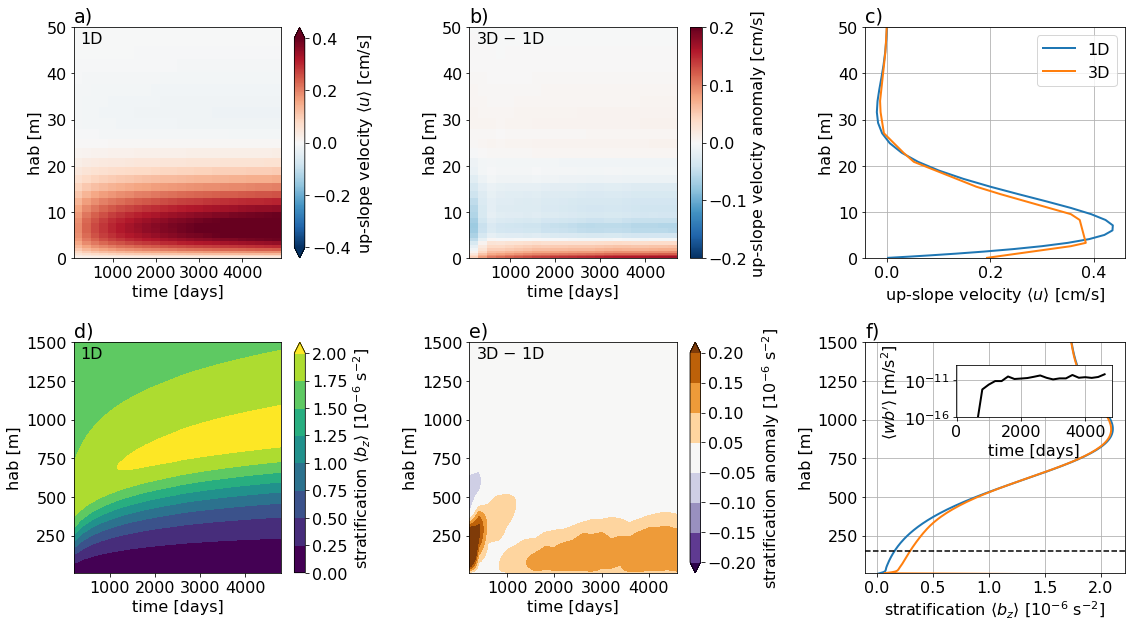

In [77]:
time = -1
Nsqlevels = np.arange(0., 2.25, 2.5e-1)
xyann = (0.03, 0.93)
xticks = np.arange(1000, 5000, 1000)

fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(2, 3)

### XY
ax = fig.add_subplot(gs[0, 0])
q = (bbl_output['default']['u']*100).plot(ax=ax, x='time', label = r"up-slope velocity $\langle u \rangle$ [cm/s]", vmin=-0.4, vmax=0.4, cmap='RdBu_r', extend='both')
q.colorbar.set_label(r"up-slope velocity $\langle u \rangle$ [cm/s]")
ax.set_ylim([0,50])
ax.set_ylabel("hab [m]")
ax.set_xlabel("time [days]")
ax.set_xticks(xticks)
ax.annotate("1D", xy=xyann, xycoords='axes fraction')
ax.set_title("a)", loc='left')

ax = fig.add_subplot(gs[0, 1])
q = ((temp['UVEL_hab'].mean(['XG', 'YC']) - bbl_output['default']['u'][:-1,:].values)*100).plot(ax=ax, x='time', cmap='RdBu_r', vmin=-0.2, vmax=0.2)
q.colorbar.set_label(r"up-slope velocity anomaly [cm/s]")
ax.set_ylim([0,50])
ax.set_ylabel("hab [m]")
ax.set_xlabel("time [days]")
ax.set_xticks(xticks)
ax.annotate(r"3D $-$ 1D", xy=xyann, xycoords='axes fraction')
ax.set_title("b)", loc='left')

ax = fig.add_subplot(gs[0, 2])
(bbl_output['default']['u']*100).isel(time=time).plot(ax=ax, y='Z', label='1D', lw=2.)
(temp['UVEL_hab']*100).mean(['XG', 'YC']).isel(time=time).plot(ax=ax, y='habW', label='3D', lw=2.)
ax.set_ylim([0,50])
ax.set_title("")
ax.set_ylabel("hab [m]")
ax.set_xlabel(r"up-slope velocity $\langle u \rangle$ [cm/s]")
ax.grid(True)
ax.legend()
ax.set_title("c)", loc='left')

ax = fig.add_subplot(gs[1, 0])
q = (bbl_output['default']['bz']*1e6).plot.contourf(ax=ax, x='time', cmap="viridis", levels=Nsqlevels)
q.colorbar.set_label(r"stratification $\langle b_{z} \rangle$ [10$^{-6}$ s$^{-2}$]")
ax.set_ylim([10,1500])
ax.set_ylabel("hab [m]")
ax.set_xlabel("time [days]")
ax.set_xticks(xticks)
ax.annotate("1D", xy=xyann, xycoords='axes fraction')
ax.set_title("d)", loc='left')

ax = fig.add_subplot(gs[1, 1])
Nsqlevels_sym = np.append(np.arange(-0.2, 0., 5.e-2), np.arange(5.e-2, 0.25, 5.e-2))
q = ((temp['dBdz_hab'].mean(['XC', 'YC']) - bbl_output['default']['bz'][:-1,:].values)*1e6).plot.contourf(ax=ax, x='time', cmap="PuOr_r", levels=Nsqlevels_sym, extend='both')
q.colorbar.set_label(r"stratification anomaly [10$^{-6}$ s$^{-2}$]")
ax.set_ylim([10,1500])
ax.set_ylabel("hab [m]")
ax.set_xlabel("time [days]")
ax.set_xticks(xticks)
ax.annotate(r"3D $-$ 1D", xy=xyann, xycoords='axes fraction')
ax.set_title("e)", loc='left')

ax = fig.add_subplot(gs[1, 2])
(bbl_output['default']['bz']*1e6).isel(time=time).plot(ax=ax, y='Zl', lw=2.)
(temp['dBdz_hab'].mean(['XC', 'YC'])*1e6).isel(time=time).plot(ax=ax, y='habC', lw=2.)
ax.set_ylim([10,1500])
ax.set_ylabel("hab [m]")
ax.set_xlabel(r"stratification $\langle b_{z} \rangle$ [10$^{-6}$ s$^{-2}$]")
ax.set_title("")
ax.grid(True)
ax.axhline(150., color='k', linestyle='--')
ax.set_title("f)", loc='left')
axins = plt.axes([0, 0, 1, 1])
axins.set_alpha(0.5)
ip = InsetPosition(ax, [0.35, 0.675, 0.6, 0.225]) #posx, posy, width, height
axins.set_axes_locator(ip)
wb_150.plot(ax=axins, x='time', yscale='log', color='k', lw=2.)
axins.set_title("")
axins.set_ylabel(r"$\langle wb' \rangle$ [m/s$^{2}$]")
axins.set_xlabel("time [days]")
axins.set_ylim([1.e-16, 1.e-9])
axins.grid(True)

plt.tight_layout()
plt.savefig("../../figures/BBTRE/1D_3D_comparison.png", bbox_inches='tight', dpi=150.)